# Additional training CV model for balls predictions
## Simple ball prediction. Balls.
Я очень не люблю машинное обучение за то, что нам рассказывают 1203912_3981239047_19203712098_712980379812 штук по применению, которые невозможно грамотно изучить за такой короткий срок. В итоге мы обладаем максимально рандомными знаниями.

Я с таким нежеланием сажусь за выполнение каждого дз, а это мне кажется в 200 раз сложнее, потому что мне не дали ноутбука, где написано, куда и какой код нужно вставить.

## Домашнее задание

В данном задании вам предлагается решить стандартную задачу детекции мячей

1. Выбрать предобученную модель: https://pytorch.org/vision/stable/models.html , https://paperswithcode.com/sota/object-detection-on-coco
2. Создать класс датасета и даталоадера: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
3. Добавить аугментаций: https://pytorch.org/vision/master/transforms.html , https://albumentations.ai/docs/introduction/image_augmentation/
4. Дообучить несколько эпох
5. Рассчитать качество (mAP)

## Data
Данные для семинара можно скачать по ссылке: https://disk.yandex.ru/d/D-q6ahy6j8Jfow

In [30]:
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import cv2
import seaborn as sns
import json
from torchvision.transforms.functional import resize

import numpy as np
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device is:", device)

Device is: cpu


In [25]:
add_path = "data/seminar_objdet_retina_oi5_ball"
train_annotations_file = f"{add_path}/oi5_ball_filename_to_bbox_train.json"
val_annotations_file = f"{add_path}/oi5_ball_filename_to_bbox_val.json"
image_dir = add_path
predictions_annotation_file = f"{add_path}/oi5_ball_filename_to_bbox_pred.json"
model_save_path = "weights.pth"
model_load_path = "weights.pth"


In [131]:
def show_image(image, figsize=(10, 10)):
    plt.figure(figsize=figsize)
    plt.imshow(image)
    plt.axis("off")
    plt.show()


def draw_predictions(image, bboxes, scores, class_to_label_map=None, threshold=0.5, label="Test"):
    palette = sns.color_palette(None, len(class_to_label_map))
    image_with_predictions = image.copy()
    
    for bbox, score in zip(bboxes, scores):
        if score < threshold:
            continue
        
        x1, y1, x2, y2 = bbox.numpy().astype(np.int32)
        label = "{:.4f}".format(float(score))
        # color = palette[class_int.item()]
        color = palette[0]
        
        cv2.rectangle(image_with_predictions, (x1, y1), (x2, y2), np.array(color) * 255, 2)
        if class_to_label_map is not None:
            cv2.putText(image_with_predictions, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, np.array(color) * 255, 2)
        
        
    return image_with_predictions


def make_tensor(image, device=None):
    tensor = transforms.functional.to_tensor(image).unsqueeze(0)
    tensor = transforms.functional.normalize(tensor,
                       mean=(0.485, 0.456, 0.406),
                       std=(0.229, 0.224, 0.225))
    if device:
        tensor = tensor.to(device)
    return tensor

Image shape (683, 1024, 3)
Tensor size torch.Size([1, 3, 683, 1024])


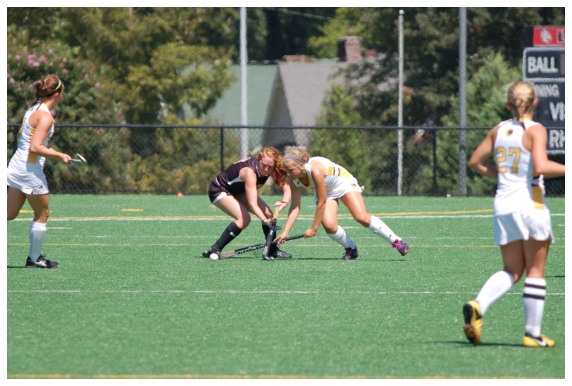

In [15]:
import cv2

for i in range(5, 6):
    image = cv2.imread(f"{add_path}/oi5_ball/000{i}.jpg")
    image_example = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    print("Image shape", image_example.shape)

    tensor_example = make_tensor(image_example, device)
    print("Tensor size", tensor_example.size())

    show_image(image_example)

## Выбор предобученной модели

In [16]:
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# Загрузка предобученной модели Faster R-CNN
model = fasterrcnn_resnet50_fpn(pretrained=True)


## Создание класса датасета и даталоадера

In [76]:
class CustomBallDataset(Dataset):
    def __init__(self, image_dir, annotations_file, transform=None, target_transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.target_transform = target_transform

        with open(annotations_file, "r") as f:
            self.annotations = json.load(f)

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        image_name = list(self.annotations.keys())[idx]
        image_path = os.path.join(self.image_dir, image_name)
        image = Image.open(image_path).convert("RGB")

        # w, h = image.shape
        w, h = 800, 800

        target = self.annotations[image_name]
        boxes = []
        labels = []

        for bbox in target:
            xmin = bbox[0] * w
            xmax = bbox[1] * w
            ymin = bbox[2] * h
            ymax = bbox[3] * h
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(1)  # Класс "ball" имеет метку 1


        target = {}
        target["image_id"] = torch.tensor([idx])
        target["boxes"] = torch.tensor(boxes, dtype=torch.float32)
        target["labels"] = torch.tensor(labels, dtype=torch.int64)

        if self.transform:
            image = self.transform(image)

        if self.target_transform:
            target = self.target_transform(target)

        return image, target

In [54]:
class ZeroBallDataset(Dataset):
    def __init__(self, image_dir, annotations_file, transform=None):
        self.image_dir = image_dir
        self.annotations = annotations_file
        self.transform = transform
        self.max_objects = 10  # Максимальное количество объектов в каждом изображении
        self.dummy_bbox = [0, 0, 0, 0] 

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        image_name = list(self.annotations.keys())[idx]
        image_path = os.path.join(self.image_dir, image_name)
        image = Image.open(image_path).convert("RGB")
        w, h = image.size

        target = self.annotations[image_name]
        boxes = []
        labels = []
        num_objects = len(target)

        # Если объектов меньше, чем self.max_objects, добавьте фиктивные аннотации
        for i in range(self.max_objects):
            if i < num_objects:
                annotation = target[i]
                xmin, xmax, ymin, ymax = annotation
                boxes.append([xmin, ymin, xmax, ymax])
                labels.append(1)  # Предположим, что все объекты - это мячи
            else:
                # Добавляем фиктивные аннотации
                boxes.append(self.dummy_bbox)
                labels.append(0)  # Фиктивный класс для отсутствующих объектов


        target = {}
        target["image_id"] = torch.tensor([idx])
        target["boxes"] = torch.tensor(boxes, dtype=torch.float32)
        target["labels"] = torch.tensor(labels, dtype=torch.int64)

        if self.transform:
            image = self.transform(image)

        return image, target

## Добавление аугментаций

In [80]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

def train_transform(image, target):
    image = image.numpy()
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    transform = A.Compose([
        A.RandomResizedCrop(height=300, width=300, scale=(0.8, 1.0)),
        A.HorizontalFlip(p=0.5),
        A.ColorJitter(p=0.2),
        A.Normalize(mean=mean, std=std),
        ToTensorV2()
    ])

    transformed = transform(image=image, bboxes=target["boxes"], labels=target["labels"])
    image = transformed["image"]
    target["boxes"] = transformed["bboxes"]
    target["labels"] = transformed["labels"]

    return image, target


def val_transform(image, target):
    image = image.numpy()
    transform = A.Compose([
        A.Resize(height=800, width=800),
        ToTensorV2()
    ])

    transformed = transform(image=image, bboxes=target["boxes"], labels=target["labels"])
    image = transformed["image"]
    target["boxes"] = transformed["bboxes"]
    target["labels"] = transformed["labels"]

    return image, target

In [77]:
train_transform = transforms.Compose([
    transforms.Resize((800, 800)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


val_transform = transforms.Compose([
    transforms.Resize((800, 800)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


# Создание датасета
train_dataset = CustomBallDataset(image_dir, train_annotations_file, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

val_dataset = CustomBallDataset(image_dir, val_annotations_file, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=True)


## Тесты

In [82]:
images, targets = train_dataset[0]

oi5_ball/0256.jpg 0


In [83]:
images.shape, targets['boxes'].shape, targets['labels'].shape, targets['image_id'].shape

(torch.Size([3, 800, 800]),
 torch.Size([6, 4]),
 torch.Size([6]),
 torch.Size([1]))

In [83]:
images, targets = next(iter(train_loader))

oi5_ball/0384.jpg 115


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


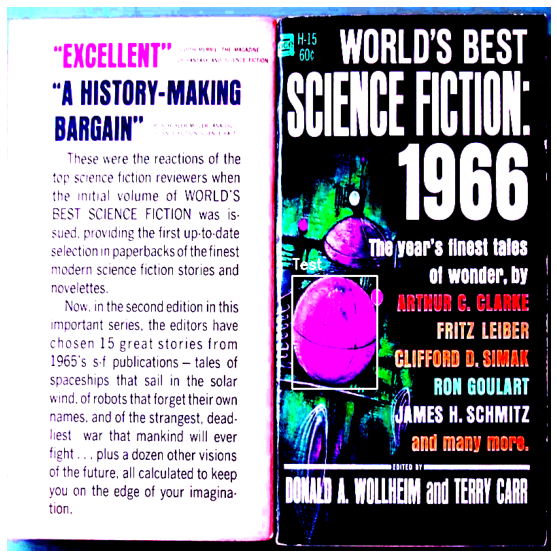

In [88]:
image = images[0].permute(1,2,0).numpy()

image_with_predictions = draw_predictions(image, targets['boxes'][0], scores=[1], class_to_label_map=[1])
show_image(image_with_predictions)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


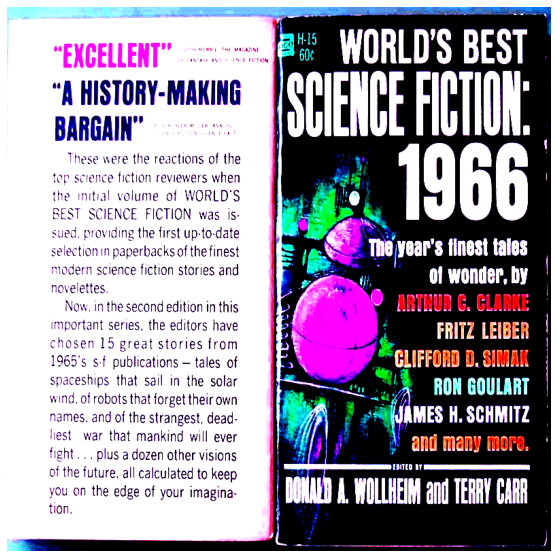

(torch.Size([1, 1, 4]), torch.Size([1, 1]))

In [89]:
show_image(images[0].permute(1,2,0))
targets['boxes'].shape, targets['labels'].shape

## Обучение модели

In [20]:
# Изменяем количество классов для детекции (1 класс - мяч)
num_classes = 2  # 1 (мяч) + 1 (фон)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# Добавим GPU поддержку, если доступен
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Оптимизатор и функция потерь
# optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9)
# criterion = torch.nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = torch.nn.SmoothL1Loss()

In [91]:
# Обучение модели на нескольких эпохах
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    for images, batched_targets in train_loader:
        images = list(image.to(device) for image in images)
        targets = []

        for i in range(len(images)):
            image_id = batched_targets['image_id'][i] 
            boxes = batched_targets['boxes'][i]
            labels = batched_targets['labels'][i]

            target = {
                "boxes": boxes,
                "labels": labels
            }

            target["image_id"] = image_id
            targets.append(target)
        
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {losses.item()}")


    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {losses.item()}")


Epoch 1/1, Loss: 2.530271291732788
Epoch 1/1, Loss: 0.25143373012542725
Epoch 1/1, Loss: 0.7650840282440186
Epoch 1/1, Loss: 2.258132219314575
Epoch 1/1, Loss: 4.827706813812256
Epoch 1/1, Loss: 6.808921813964844
Epoch 1/1, Loss: 4.895984649658203
Epoch 1/1, Loss: 1.0989975929260254


KeyboardInterrupt: 

In [92]:
losses

tensor(0.7886, grad_fn=<AddBackward0>)

## Это я обучал всю ночь, и в итоге выводился nan Loss. (Показано время исполнения 815 мин ~ 13.5 часов)
![Screenshot from 2023-10-21 09-12-45.png](<attachment:Screenshot from 2023-10-21 09-12-45.png>)
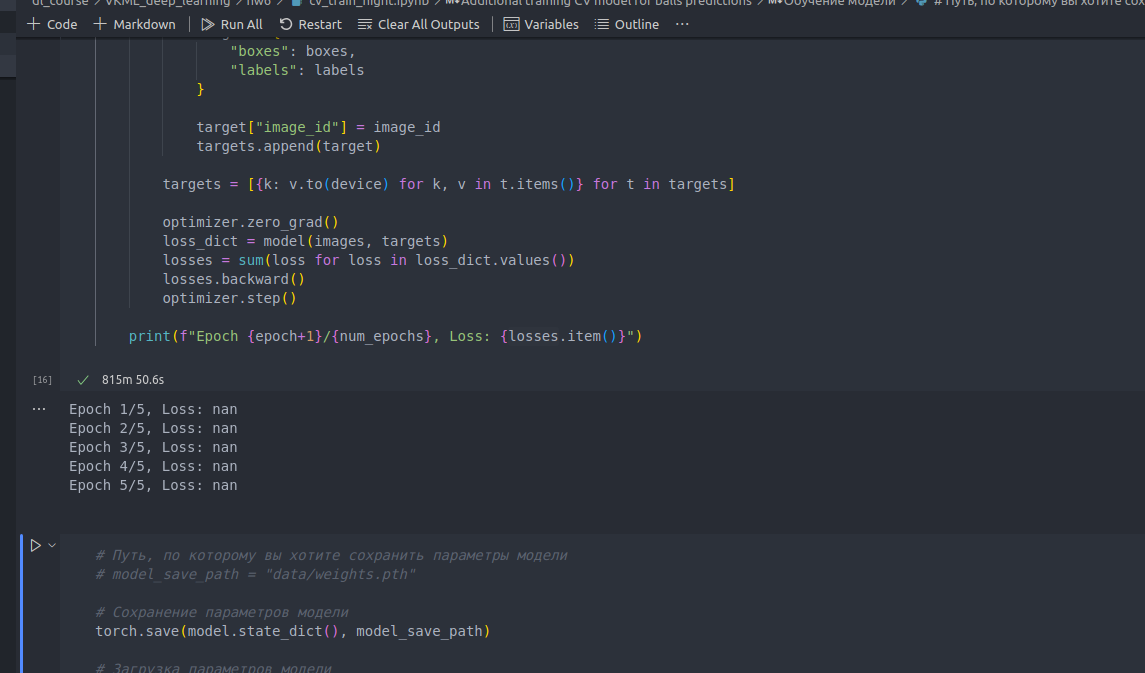
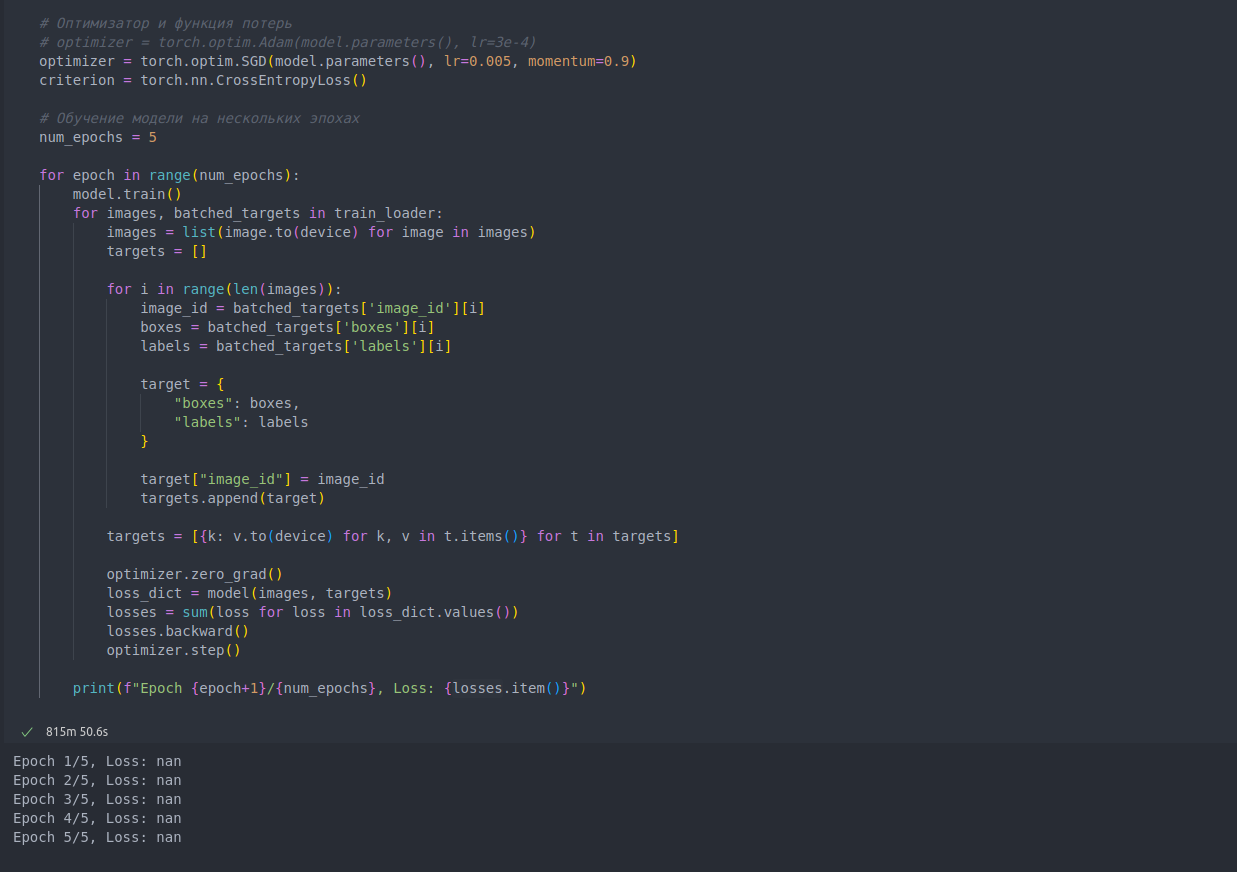

### Save weights

In [99]:
# model_save_path = "weights.pth"

# torch.save(model.state_dict(), model_save_path)

<All keys matched successfully>

### Load weights

In [130]:
# model_load_path = "data/weights.pth"

model = fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model.to(device)

model.load_state_dict(torch.load(model_load_path, map_location=torch.device(device)))


/home/timofey/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/timofey/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

## Рассчет качества (mAP)

In [126]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

# add_path = "data/seminar_objdet_retina_oi5_ball"
# train_annotations_file = f"{add_path}/oi5_ball_filename_to_bbox_train.json"
# val_annotations_file = f"{add_path}/oi5_ball_filename_to_bbox_val.json"
# image_dir = add_path
# predictions_annotation_file = f"{add_path}/oi5_ball_filename_to_bbox_pred.json"

# Загрузка ground truth аннотаций
coco_gt = COCO(val_annotations_file)
COUNT = 1

# Создание списка для предсказаний модели в формате COCO
predictions = []
model.eval()
with torch.no_grad():
    for images, batched_targets in val_loader:
        COUNT += 1
        if COUNT > 5:
            break
        images = list(image.to(device) for image in images)
        predictions_batch = model(images)
        for i in range(len(images)):
            image_id = int(batched_targets['image_id'][i].item())
            prediction = predictions_batch[i]
            boxes = prediction["boxes"].cpu().numpy()
            scores = prediction["scores"].cpu().numpy()
            labels = prediction["labels"].cpu().numpy().tolist()

            for box, score, label in zip(boxes, scores, labels):
                predictions.append({
                    "image_id": image_id,
                    "category_id": label,
                    "bbox": [float(coord) for coord in box],
                    "score": float(score)
                })

# Сохранение предсказаний в формате COCO
with open(predictions_annotation_file, "w") as f:
    json.dump(predictions, f)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
oi5_ball/0228.jpg 202
oi5_ball/0009.jpg 8
oi5_ball/0194.jpg 172
oi5_ball/0027.jpg 24
oi5_ball/0154.jpg 138


In [111]:

# Загрузка предсказаний для оценки
coco_dt = coco_gt.loadRes(predictions_annotation_file)

# Выполнение оценки
coco_eval = COCOeval(coco_gt, coco_dt, iouType='bbox')
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()


KeyError: 'images'

## Посмотрим на предсказания

oi5_ball/0075.jpg 70


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


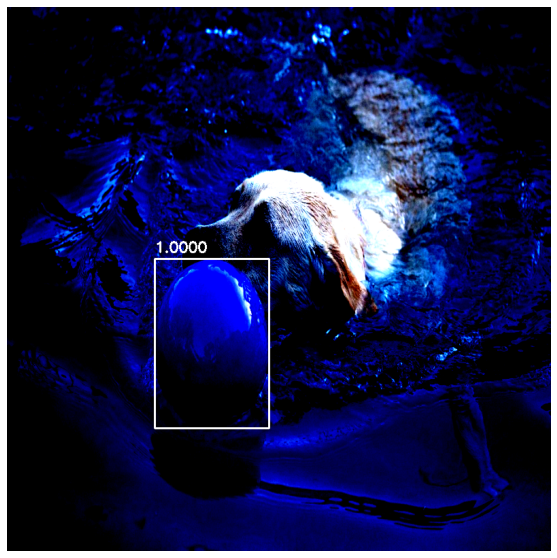

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


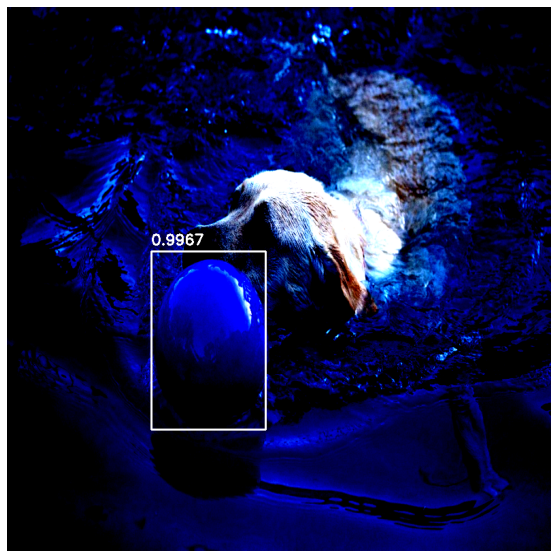

{'boxes': tensor([[212.8750, 359.3425, 380.4968, 621.6156],
        [422.0997,  82.0719, 675.5003, 481.0053],
        [279.2717, 244.6099, 535.3543, 457.1761],
        [227.9027, 261.8954, 453.9312, 656.2764],
        [185.8183, 226.5219, 562.4901, 702.0458],
        [261.6422, 326.4459, 304.4333, 377.7640],
        [703.8677, 561.6779, 800.0000, 710.3799],
        [230.5169, 368.6091, 374.3881, 476.0304],
        [317.7177, 194.0396, 509.8852, 618.9231],
        [227.1294, 464.5957, 378.6195, 599.7811],
        [226.9161, 391.8935, 359.9005, 551.9549],
        [262.0008, 375.6724, 354.2814, 395.6693],
        [213.3101, 586.1003, 374.5752, 722.7693],
        [303.4124,  42.2334, 695.7933, 655.8455],
        [ 60.6607, 347.7203, 518.7579, 638.5552],
        [398.1440, 101.1739, 663.1306, 314.0876]]), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]), 'scores': tensor([0.9967, 0.3188, 0.2731, 0.2581, 0.2307, 0.2267, 0.1735, 0.1687, 0.1609,
        0.1112, 0.0879, 0.0783

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


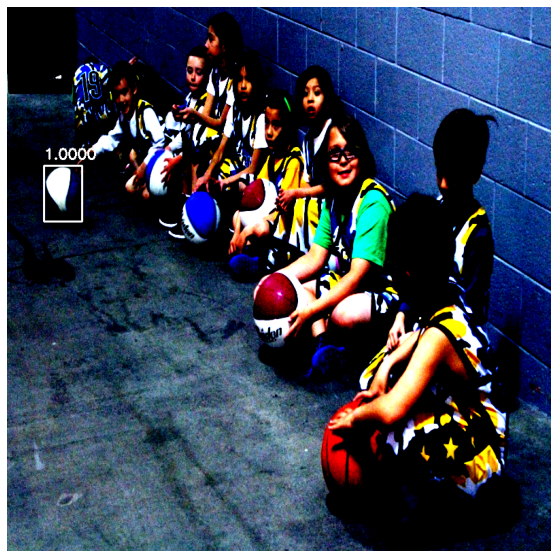

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


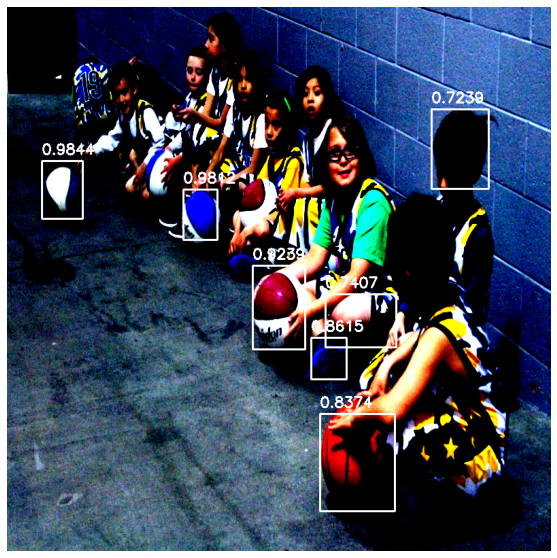

{'boxes': tensor([[ 51.5625, 226.4233, 111.6246, 311.7083],
        [259.9028, 268.2758, 309.6419, 342.5927],
        [361.3296, 380.0215, 438.9290, 503.0222],
        [447.2017, 486.9550, 499.2101, 547.4836],
        [460.3470, 598.1402, 570.9382, 741.3868],
        [468.9197, 422.4423, 572.8159, 500.4148],
        [624.2787, 150.1250, 708.1705, 267.5403],
        [ 56.5433, 235.9554,  98.3112, 293.8086],
        [438.4631, 510.2849, 760.4899, 788.4902],
        [628.7432, 454.5859, 678.7892, 491.0856],
        [364.2207, 388.6137, 429.9539, 460.5061],
        [501.6372, 364.3156, 533.7714, 414.2531],
        [566.1188, 278.9504, 654.7601, 419.6674],
        [342.5979, 254.0270, 382.3417, 302.5391],
        [461.7791, 407.7116, 600.9073, 542.8730],
        [ 81.5286, 243.3206, 109.5506, 309.1807],
        [611.6131, 449.8441, 677.9194, 507.0675],
        [538.4567, 415.3398, 579.1818, 451.7330],
        [600.7676, 454.2947, 704.5198, 558.0547],
        [336.2221, 243.6877, 357.0278, 2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


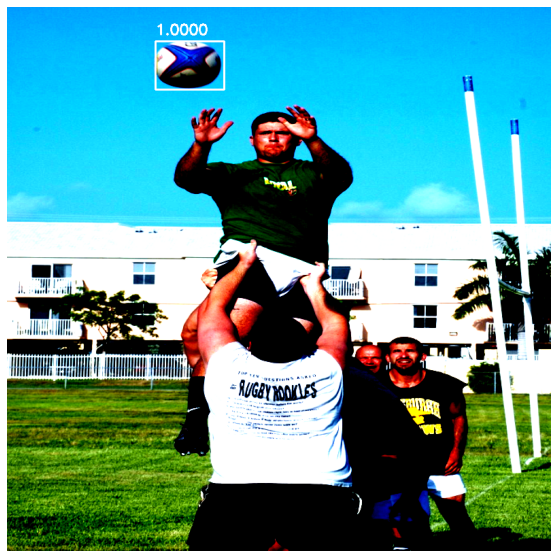

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


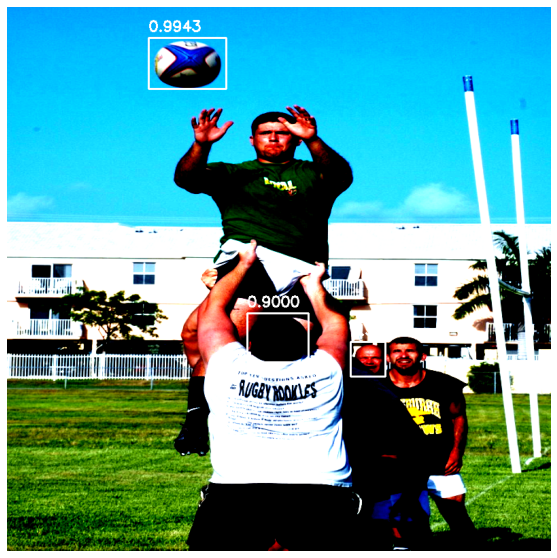

{'boxes': tensor([[208.5914,  45.3467, 322.3131, 120.0061],
        [353.6594, 450.0456, 443.2839, 522.9182],
        [505.0806, 492.2664, 556.5672, 543.4933],
        [358.3187, 154.8323, 427.1137, 232.3464],
        [276.4126, 437.0053, 504.7685, 706.4475],
        [240.8961, 227.8646, 314.1505, 271.9532],
        [285.8582, 232.8121, 307.0802, 264.5345],
        [486.5081, 537.1168, 576.0706, 691.4210],
        [232.7509, 521.3671, 649.4968, 707.3438],
        [337.1565, 355.3993, 363.2215, 376.7389],
        [242.4503, 196.4483, 304.5894, 276.7640],
        [324.2076, 424.9222, 380.7087, 483.6510],
        [286.3541, 380.4942, 309.8371, 417.0074],
        [290.9297, 142.3357, 317.6180, 174.7695],
        [311.1352, 338.3698, 346.6859, 372.1066],
        [294.7821, 494.3505, 374.5641, 598.9092],
        [268.4962, 233.1497, 308.8950, 269.9836],
        [402.4282, 137.5498, 450.8704, 197.0807],
        [512.9494, 496.3744, 554.1767, 526.1856],
        [454.6254, 207.1535, 502.6272, 2

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


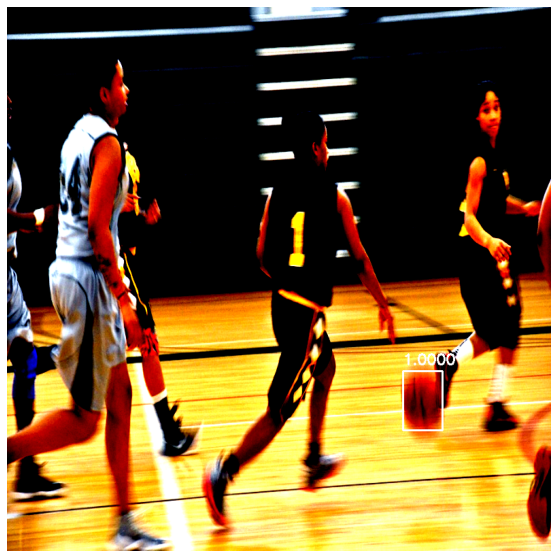

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


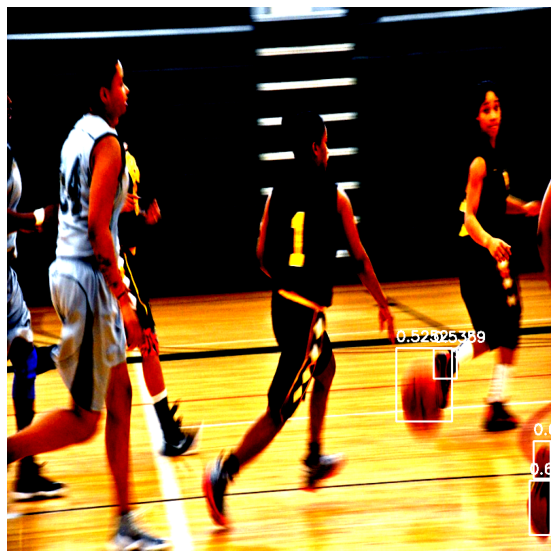

{'boxes': tensor([[768.6034, 696.1118, 799.4824, 776.1902],
        [774.4164, 638.8818, 799.3195, 693.7969],
        [627.1016, 502.8083, 661.2632, 546.2793],
        [572.9615, 501.6259, 654.8538, 609.0641],
        [ 72.7495, 155.8319, 166.9446, 311.0526],
        [653.7781, 490.7299, 685.0961, 522.9825],
        [677.3324, 218.0799, 707.0587, 260.3893],
        [441.7400, 190.7060, 473.4316, 245.2728],
        [403.1646, 150.6018, 428.7648, 187.1415],
        [401.5864, 148.9392, 467.4941, 196.1194],
        [576.4637, 537.9088, 642.8746, 603.0037],
        [ 77.4095, 162.7424, 161.2617, 228.9409],
        [189.0371, 270.2298, 229.3755, 333.8996],
        [104.9569,  41.4283, 176.8640, 176.2802],
        [ 93.4480, 158.6230, 157.8637, 192.5499],
        [411.9172, 142.7938, 466.5155, 240.6455],
        [629.7590, 493.3246, 689.8179, 528.4451],
        [129.9895,  91.7273, 178.0219, 174.5355],
        [480.7146, 264.2266, 507.5132, 327.8601],
        [ 63.6313, 382.5817, 120.0491, 4

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


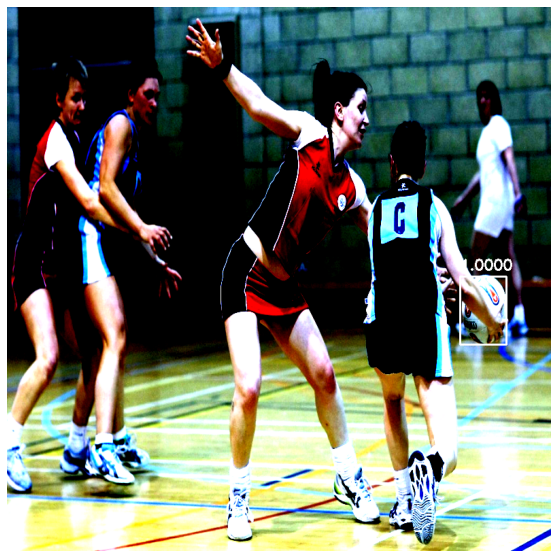

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


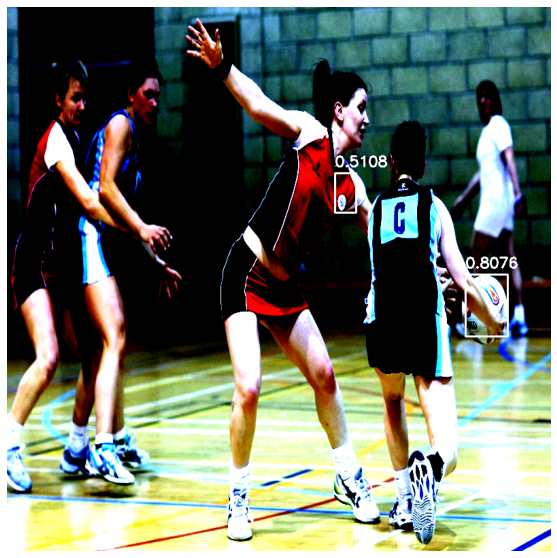

{'boxes': tensor([[674.6974, 393.1458, 736.0839, 484.5558],
        [482.3553, 244.5850, 513.0993, 302.6898],
        [351.0793, 369.3148, 429.2741, 438.8898],
        [429.3881, 308.4447, 536.4439, 465.7672],
        [485.7960, 275.2071, 500.2535, 298.7219],
        [631.8812, 389.9173, 745.9279, 474.4232],
        [692.9861, 154.8906, 746.4103, 250.6096],
        [196.9702, 321.0139, 242.2483, 364.8051],
        [322.2639, 725.3929, 362.2373, 788.1649],
        [129.8484, 138.1134, 195.4296, 294.1938],
        [382.3769, 149.5192, 450.3302, 193.2094],
        [141.6038, 152.5581, 188.1467, 214.6295],
        [ 79.3941, 112.2253, 355.2398, 343.2946],
        [670.9080, 442.0450, 681.7431, 458.6891],
        [566.1141, 160.5379, 614.7271, 251.5505],
        [612.0698, 631.0011, 663.1132, 695.7867],
        [402.0174, 151.6285, 435.3344, 199.3040],
        [160.3771, 216.6212, 191.0316, 283.0848],
        [698.4692, 158.2687, 742.5652, 214.5464],
        [ 67.6343,  71.0940, 118.1853, 1

In [135]:
is_val = True
max_count = 5
loader = val_loader if is_val else train_loader

model.eval()

with torch.no_grad():
    cur = 0
    for images, targets in loader:
        cur += 1
        if cur > max_count:
            break
        predictions_batch = model(images)
        if len(predictions_batch[0]['boxes']) > 0:
            image = images[0].permute(1,2,0).numpy()
            image_trust = draw_predictions(image, targets['boxes'][0], scores=[1], class_to_label_map=[1])
            show_image(image_trust)
            
            image_with_predictions = draw_predictions(image, predictions_batch[0]['boxes'], scores=predictions_batch[0]['scores'], class_to_label_map=predictions_batch[0]['labels'], label="Val")
            show_image(image_with_predictions)
            print(predictions_batch[0])
        else:
            print(f"{i} iteration empty results")
